<a href="https://colab.research.google.com/github/wasifferoze/NMA/blob/main/yang_load_stringer_orientations_wasif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [ ]:
dat['stat'][0]

{'aspect_ratio': 1.2440451650058602,
 'compact': 1.0741931450594069,
 'footprint': 1.0,
 'ipix': array([107373, 107374, 107375, 107862, 107863, 107864, 107865, 107866,
        107867, 107868, 107869, 107870, 108351, 108352, 108353, 108354,
        108355, 108356, 108357, 108358, 108359, 108839, 108840, 108841,
        108842, 108843, 108844, 108845, 108846, 108847, 108848, 108849,
        109328, 109329, 109330, 109331, 109332, 109333, 109334, 109335,
        109336, 109337, 109816, 109817, 109818, 109819, 109820, 109821,
        109822, 109823, 109824, 110304, 110305, 110306, 110307, 110308,
        110309, 110310, 110311, 110312, 110794, 110795, 110796, 110797,
        110798, 110799, 111282, 111283, 111284, 111285, 111286, 111287,
        111771, 111772, 111773, 111774, 112260, 112261, 112262],
       dtype=int32),
 'lam': array([ 1.4267471,  1.8092183,  1.9675549,  1.6410617,  4.053359 ,
         5.973709 ,  5.8645153,  6.0527835,  6.558485 ,  6.275843 ,
         6.5751143,  5.4931

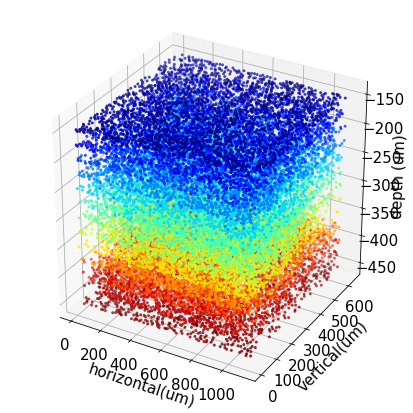

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

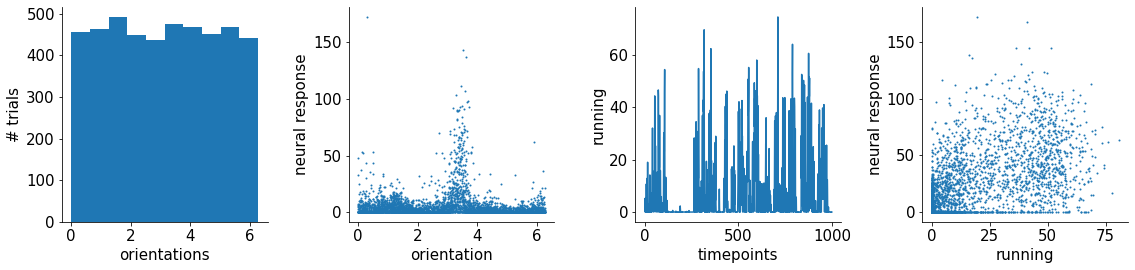

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

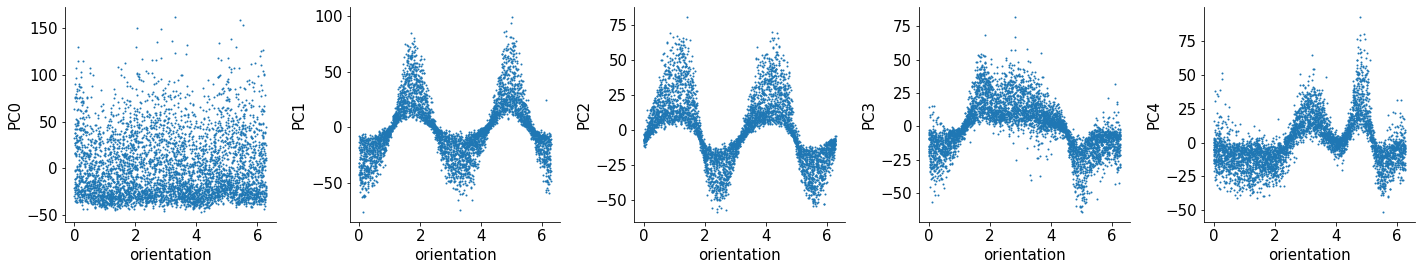

In [ ]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn --quiet
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


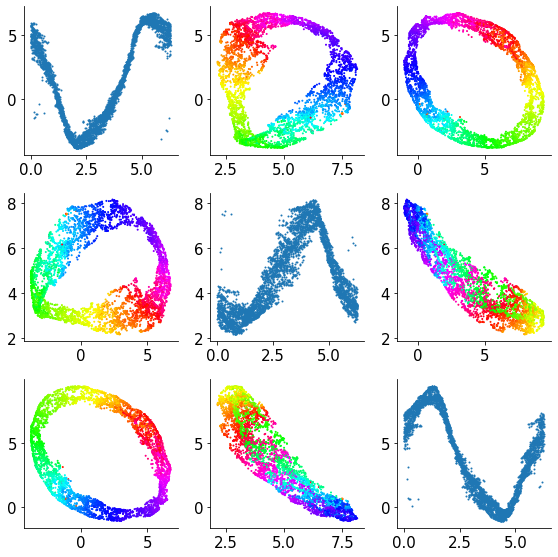

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')


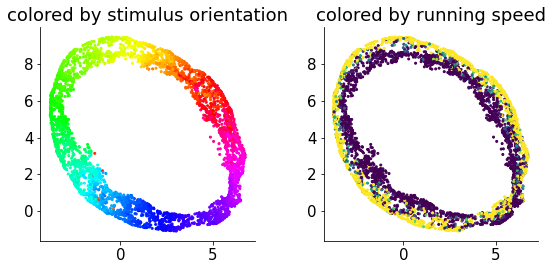

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2, 1)
plt.scatter(embed[:,0], embed[:,2], s  = 4, c= dat['istim'], cmap = 'hsv')
plt.title('colored by stimulus orientation');

plt.subplot(1,2, 2)
plt.scatter(embed[:,0], embed[:,2], s  = 4, c= dat['run'], vmin = 0, vmax = 10)
plt.title('colored by running speed');

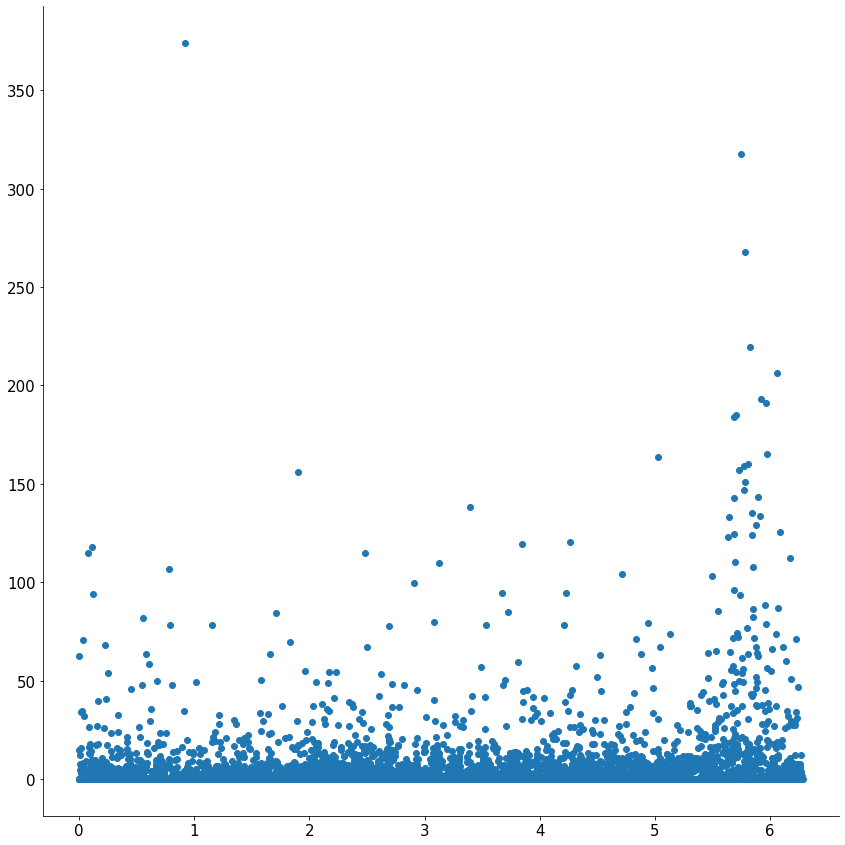

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(dat['istim'], dat['sresp'][0])

In [ ]:
import pandas as pd
def calculate_orientation_response_curve(neuron_response, orientations, bins=360, window1=15, window2=5, plot=False):
  df = pd.DataFrame({'orientation':np.floor(orientations/(np.pi*2)*bins), 'response':neuron_response})
  k = (df.groupby('orientation').mean())['response'].to_numpy() - np.mean(neuron_response)
  k = np.convolve(np.ones(window1)/window1, k, mode='same')
  k = np.convolve(np.ones(window2)/window2, k, mode='same')
  k = k/max(k)
  xspace = np.linspace(0, np.pi*2, num=bins, endpoint=False)
  if plot:
    plt.figure(figsize=(8, 8))
    plt.plot(xspace, k)
  return xspace, k

def calculate_orientation_selectivity(neuron_response, orientations):
  bins=360
  window1=15
  window2=5 
  xspace, k = calculate_orientation_response_curve(neuron_response, orientations, bins, window1, window2, plot=False)
  return xspace[np.argmax(k)]

In [ ]:
calculate_orientation_selectivity(dat['sresp'][2], dat['istim'])

2.652900463031381

In [ ]:
from scipy.stats import moment
def compute_moment(id, max_moment=4):
  _, curve = calculate_orientation_response_curve(dat['sresp'][id], dat['istim'])
  return np.array([moment(curve, axis=0, moment=i+1) for i in range(max_moment)])

num_neurons=dat['sresp'].shape[0]
moment_array = np.zeros((num_neurons, 4))
for i in range(num_neurons):
  moment_array[i] = compute_moment(i)

In [ ]:
df_stats_neurons = pd.DataFrame(np.hstack([np.array(list(range(num_neurons))).reshape(-1,1), moment_array]))
df_stats_neurons.columns=['id', 'moment_1','moment_2','moment_3','moment_4']
df_stats_neurons.drop('moment_1', axis=1, inplace=True)
df_stats_neurons.head()

,id,moment_2,moment_3,moment_4
0,0.0,0.046597,0.032478,0.028432
1,1.0,0.088572,0.039892,0.039404
2,2.0,0.181065,0.018201,0.078734
3,3.0,0.069751,0.043699,0.037801
4,4.0,0.116547,0.026813,0.039611


In [ ]:
df_stats_neurons.describe()

,id,moment_2,moment_3,moment_4
count,23589.000000,23589.000000,23589.000000,23589.000000
mean,11794.000000,0.105311,0.040217,0.049231
std,6809.702086,0.051213,0.016152,0.026175
min,0.000000,0.033154,-0.199462,0.016899
25%,5897.000000,0.067643,0.031945,0.033071
50%,11794.000000,0.092894,0.039085,0.042280
75%,17691.000000,0.129931,0.048701,0.056917
max,23588.000000,0.503977,0.117643,0.526917


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48025c81d0>,
      dtype=object)

<Figure size 1152x1152 with 0 Axes>

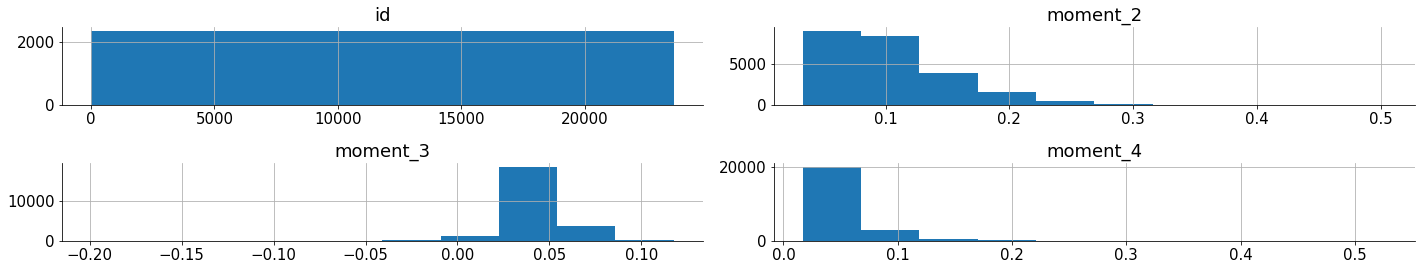

In [ ]:
plt.figure(figsize=(16,16))
df_stats_neurons.hist()

In [ ]:
df_filted = df_stats_neurons[np.logical_and(df_stats_neurons['moment_2']<0.1, df_stats_neurons['moment_2']<0.06)]

In [ ]:
order1=df_stats_neurons.sort_values(by='moment_2')['id'].to_numpy(dtype='int')
order2=df_stats_neurons.sort_values(by='moment_3')['id'].to_numpy(dtype='int')
order3=df_stats_neurons.sort_values(by='moment_4')['id'].to_numpy(dtype='int')

In [ ]:
order1

array([ 7274,  3962, 10736, ..., 17977,  6091,  2711])

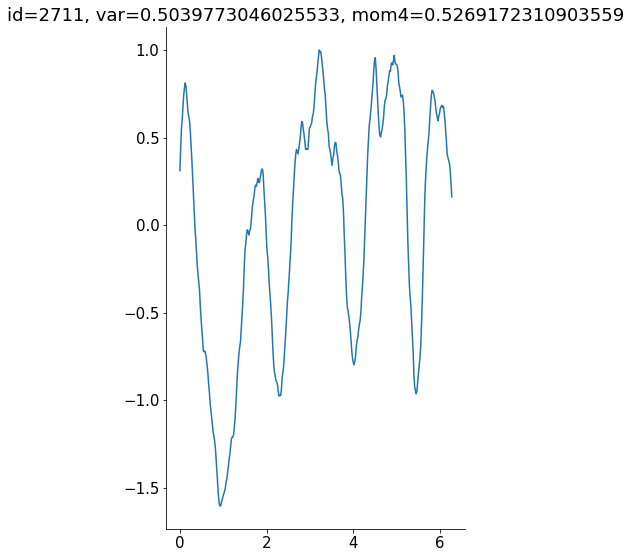

In [ ]:
def var_plot(id):
  _, k = calculate_orientation_response_curve(dat['sresp'][id], dat['istim'], plot=True)
  plt.title('id={}, var={}, mom4={}'.format(id, np.var(k), moment(k, moment=4)))

var_plot(2711)

In [ ]:
def calculate_all_orientation_selectivities(neuron_responses, orientations):
  num_neurons = neuron_responses.shape[0]
  orientations_all = np.zeros(num_neurons)
  for i in range(num_neurons):
    orientations_all[i]=calculate_orientation_selectivity(neuron_responses[i], orientations)
  return orientations_all

In [ ]:
id_filted=df_filted['id'].to_numpy(dtype='int')
resp_filted=dat['sresp'][id_filted]
filted_orientations=calculate_all_orientation_selectivities(resp_filted, dat['istim'])

In [ ]:
tmp_array = np.hstack([filted_orientations.reshape(-1,1), dat['xyz'].T[id_filted]])
tmp_array[:, 3]=-tmp_array[:, 3]

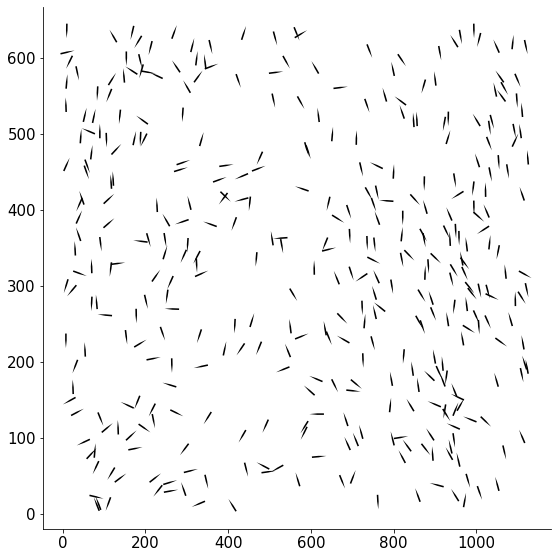

In [ ]:
import matplotlib.cm as cm
colormap=cm.inferno
l150=tmp_array[tmp_array[:, 3]==250]
plt.figure(figsize=(8, 8))
plt.quiver(l150[:, 1],l150[:, 2],np.cos(l150[:, 0]), np.sin(l150[:, 0]), color=colormap(l150[:, 0]/np.pi/2), headaxislength=0, pivot='middle', headwidth=1)
plt.show()

In [ ]:
orientations_all = calculate_all_orientation_selectivities(dat['sresp'], dat['istim'])

In [ ]:
df_orientations = pd.DataFrame({"orientation": orientations_all, 'x': dat['xyz'][0], 'y': dat['xyz'][1],'z': -dat['xyz'][2]})
df_orientations.to_csv('orientation_position.csv')
df_orientations.head()

In [ ]:
import matplotlib.cm as cm
colormap=cm.inferno
l150 = df_orientations[df_orientations['z']==200]
l150=l150.drop('z', axis=1)
plt.figure(figsize=(16,16))
plt.quiver(l150['x'],l150['y'],np.cos(l150['orientation'].to_numpy()), np.sin(l150['orientation'].to_numpy()), color=colormap(l150['orientation']/np.pi/2))
plt.show()